In [3]:
import numpy as np
from matplotlib import pyplot as plt
from numba import njit
from scipy.optimize import minimize

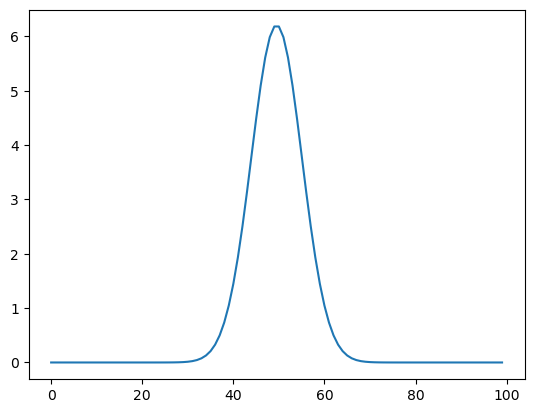

In [27]:
x = np.linspace(-5, 5, 100)
dx = x[1]-x[0]
U = (1/2)*x**2 * 10
def d(phi, dx): 
    pad = np.concatenate((np.array([0,0]), phi, np.array([0,0])))
    return ((-1/12)*pad[4:] + (2/3)*pad[3:-1] - (2/3)*pad[1:-3] + (1/12)*pad[:-4])/dx
def d(phi, dx): 
    pad = np.concatenate((np.array([0]), phi, np.array([0])))
    return (pad[2:] - pad[:-2]) / (2*dx)

def d(phi, dx): 
    pad = np.concatenate((np.array([0,0]), phi, np.array([0,0])))
    return ((-1/12)*pad[4:] + (2/3)*pad[3:-1] - (2/3)*pad[1:-3] + (1/12)*pad[:-4])/dx
def i(phi, dx):
    return np.sum(phi)*dx
def H(phi):
    phi = phi / np.sqrt(i(phi**2, dx))
    K = (1/2)*i(d(phi,dx)**2, dx)
    P = i(U*phi**2, dx)
    return K + P
initial_guess = np.ones(len(x))
result = minimize(H, initial_guess)#, method='L-BFGS-B')
plt.plot(result.x)


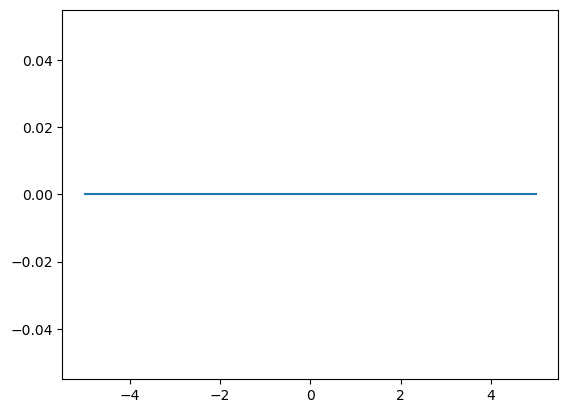

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -15246744.416506156
        x: [ 2.220e+01 -2.375e+02 ...  2.220e+01  9.559e+02]
      nit: 1
      jac: [-4.286e+03  4.463e+04 ... -4.286e+03 -1.627e+04]
 hess_inv: [[ 9.973e-01  2.857e-02 ... -2.687e-03 -3.902e-02]
            [ 2.857e-02  6.974e-01 ...  2.857e-02  3.639e-01]
            ...
            [-2.687e-03  2.857e-02 ...  9.973e-01 -3.902e-02]
            [-3.902e-02  3.639e-01 ... -3.902e-02  2.938e+00]]
     nfev: 11436
     njev: 112


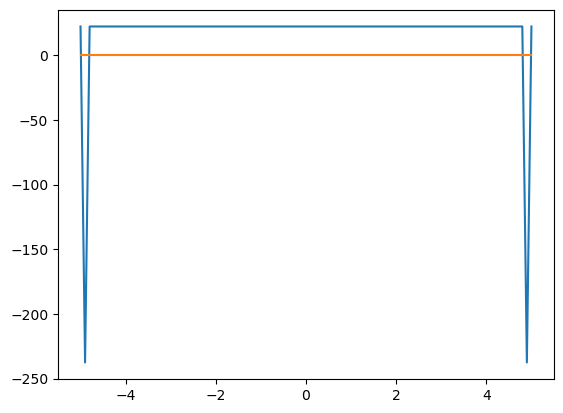

In [15]:
def solve(dx, U, g, N):
    Nx = len(U)
    assert Nx % 2 == 0
    Nh = Nx // 2   # half-size
    
    @njit
    def wannier(half_phi_s, half_phi_a):
        phi_s = np.concatenate((np.flip(half_phi_s), half_phi_s))
        phi_a = np.concatenate((-np.flip(half_phi_a), half_phi_a))
        phi_1 = (phi_a + phi_s) / np.sqrt(2)
        phi_2 = (phi_s - phi_a) / np.sqrt(2)
        return phi_1, phi_2
    @njit
    def d(phi, dx): 
        #return np.gradient(np.concatenate((np.array([0]), phi, np.array([0]))), dx)[1:-1]
        pad = np.concatenate((np.array([0]), phi, np.array([0])))

        return (pad[2:] - pad[:-2]) / (2*dx)
    #@njit
    #def d(phi, dx): 
        #return np.gradient(np.concatenate((np.array([0]), phi, np.array([0]))), dx)[1:-1]
        #pad = np.concatenate((np.array([0,0]), phi, np.array([0,0])))
        #return ((-1/12)*pad[4:] + (2/3)*pad[3:-1] - (2/3)*pad[1:-3] + (1/12)*pad[:-4])/dx
        #return (pad[2:] - pad[:-2]) / (2*dx)

    
    @njit
    def i(phi, dx):
        return np.sum(phi) * dx
    @njit
    def cost(phi_s_phi_a_C):
        half_phi_s = phi_s_phi_a_C[:Nh]
        half_phi_a = phi_s_phi_a_C[Nh:2*Nh]
        C = phi_s_phi_a_C[2*Nh:]
        C /= np.linalg.norm(C)
        #half_phi_s /= np.sqrt(2*i(half_phi_s**2, dx))
        #half_phi_a /= np.sqrt(2*i(half_phi_a**2, dx))
        phi_s = np.concatenate((np.flip(half_phi_s), half_phi_s))
        phi_a = np.concatenate((-np.flip(half_phi_a), half_phi_a))
        phi_s /= np.sqrt(i(phi_s**2, dx))
        phi_a /= np.sqrt(i(phi_a**2, dx))
        dphi_s = d(phi_s, dx)
        dphi_a = d(phi_a, dx)
        return i(dphi_s**2/2, dx) + i(U * phi_s**2, dx)# + i(dphi_a**2/2, dx) + i(U * phi_a**2, dx) + np.sum(C**2)
        #phi_1, phi_2 = wannier(half_phi_s, half_phi_a)
        #dphi_1 = d(phi_1, dx)
        #dphi_2 = d(phi_2, dx)
        #eps_11 = i(U * phi_1**2 + dphi_1**2/2, dx)
        #T_0 = i(phi_1**4, dx)
        #T_2 = i(phi_1**2 * phi_2**2, dx)
        #E_0 = eps_11*N + (1/4)*N*(N-2)*g*(T_0+T_2)
        #Jx2_C = ((np.flip(np.arange(0, len(C))) - np.arange(0, len(C)))/2)**2 * C
        #return E_0 #+ (2*g*(T_0-T_2)*C.dot(Jx2_C))
    @njit
    def cost(phi_E):
        phi = phi_E[:-1]
        E = phi_E[-1]
        dphi = d(phi, dx)
        return i(dphi**2/2 + U*phi**2, dx) - E*(i(phi**2, dx)-1)
    
    initial_guess = np.random.rand(Nx + 1)
    
    initial_guess = np.ones(Nx+1)
    #initial_guess = np.zeros(Nx+1)
    result = minimize(cost, initial_guess)
    print(result)
    return result.x[:-1], result.x[-1]

x = np.linspace(-5,5, 100)
U_max = 1
#U_well_center = 0
U_well_width = 2
#U = np.where(np.abs(np.abs(x)-U_well_center) < U_well_width/2, 0, U_max)
#U = np.zeros(len(x))
U = 10*x**2
U = np.zeros(len(x))
plt.plot(x, U)
plt.show()
dx = x[1] - x[0]
phi, E = solve(dx, U, g=0, N=10)
plt.plot(x, phi)
plt.plot(x, U)
plt.show()
#print(np.sum(phi_1**2)*dx, np.sum(phi_2**2)*dx)
#print(np.sum(C**2))

#plt.plot(x, phi_1)
#plt.plot(x, phi_2)
#plt.show()
#plt.plot(C)

In [ ]:
def d(v, dx, bcs):
    v_pad = np.concatenate((np.array([bcs[0]]), v, np.array([bcs[1]])))
    return (v_pad[2:] - v_pad[:-2]) / (2 * dx)

def H(x, c, phi_1, phi_2, U, g):
    #N = len(c)-1
    d_phi_1 = d(phi_1, x[1] - x[0], (0, 0))
    d_phi_2 = d(phi_2, x[1] - x[0], (0, 0))
    eps_11 = np.trapz(d_phi_1**2, x) + np.trapz(U*phi_1**2, x)
    #eps_12 = np.trapz(d_phi_1*d_phi_2, x) + np.trapz(U*phi_1*phi_2, x)
    #T_0 = np.trapz(phi_1**4, x)
    #T_1 = np.trapz(phi_1**3 * phi_2, x)
    #T_2 = np.trapz(phi_1**2 * phi_2**2, x)
    #Jx2_c = ((np.flip(np.arange(0, len(c))) - np.arange(0, len(c)))/2)**2 * c
    #Jz_c = (np.concatenate((np.zeros(1), c[1:])) + np.concatenate((c[:-1], np.zeros(1))))/2
    #Jz2_c = (np.concatenate((np.zeros(1), Jz_c[1:])) + np.concatenate((Jz_c[:-1], np.zeros(1))))/2
    #E0 = eps_11*N + (1/4)*N*(N-2)*(g*T_0 + g*T_2)
    #return E0 + 2*(eps_12 + g*T_1*(N-1))*c.dot(Jz_c) + 2*g*T_2*c.dot(Jz2_c) + g*(T_0 - T_2)*c.dot(Jx2_c)
    return eps_11

N = 2
g = 1
half_Nx = 100
x = np.linspace(-1, 1, 2*half_Nx)
U = x**4 - x**2
#plt.plot(x, U)

def unwrap(vec): return vec[0:N+1], vec[N+1:N+1+Nx], vec[N+1+Nx:]

def cost(vec):
    print(len(c))
    print(len(phi_a))
    print(len(phi_s))
    c, phi_a, phi_s = unwrap(vec)
    phi_a = np.concatenate((-np.flip(phi_a), phi_a))
    phi_s = np.concatenate((np.flip(phi_s), phi_s))
    phi_1 = (phi_a + phi_s)/np.sqrt(2)
    phi_2 = (phi_a - phi_s)/np.sqrt(2)
    return H(x, c, phi_1, phi_2, U, g)

from scipy.optimize import minimize
# BEGIN:

constraints = [
    {'type': 'eq', 'fun': lambda v: np.linalg.norm(unwrap(v)[0]) - 1/2},
    {'type': 'eq', 'fun': lambda v: np.trapz(unwrap(v)[1]**2, dx = x[1]-x[0]) - 1/2},
    {'type': 'eq', 'fun': lambda v: np.trapz(unwrap(v)[2]**2, dx= x[1]-x[0]) - 1/2},
]

initial_guess = np.concatenate((np.ones(N+1)/np.sqrt(N+1), np.ones(half_Nx)/np.sqrt(half_Nx), np.ones(half_Nx)/np.sqrt(half_Nx)))

result = minimize(cost, initial_guess, constraints=constraints)
print(result)


In [45]:
x = np.linspace(-1, 1, 4)
x

array([-1.        , -0.33333333,  0.33333333,  1.        ])

In [ ]:
def solve(dx, U, g, N):
    Nx = len(U)
    assert Nx % 2 == 0
    Nh = Nx // 2   # half-size
    
    @njit
    def wannier(half_phi_s, half_phi_a):
        phi_s = np.concatenate((np.flip(half_phi_s), half_phi_s))
        phi_a = np.concatenate((-np.flip(half_phi_a), half_phi_a))
        phi_1 = (phi_a + phi_s) / np.sqrt(2)
        phi_2 = (phi_s - phi_a) / np.sqrt(2)
        return phi_1, phi_2
    @njit
    def d1(phi, dx): 
        #return np.gradient(np.concatenate((np.array([0]), phi, np.array([0]))), dx)[1:-1]
        pad = np.concatenate((np.array([0]), phi, np.array([0])))
        return (pad[2:] - pad[:-2]) / (2*dx)
    @njit
    def d2(phi, dx):
        pad = np.concatenate((np.array([0]), phi, np.array([0])))
        return (pad[2:] + pad[:-2] - 2*pad[1:-1]) / (dx**2)
    @njit
    def i(phi, dx):
        return np.sum(phi) * dx
    @njit
    def normalize(phi, dx):
        return phi / np.sqrt(i(phi**2, dx))
    


    @njit
    def cost(phi_E):
        phi = phi_E[:-1]
        E = phi_E[-1]
        dphi = d(phi, dx)
        return i(dphi**2/2 + U*phi**2, dx) - E*(i(phi**2, dx)-1)
    
    initial_guess = np.random.rand(Nx + 1)
    initial_guess = np.ones(Nx+1)
    result = minimize(cost, initial_guess)
    print(result)
    return result.x[:-1], result.x[-1]

x = np.linspace(-2, 2, 100)
U_max = 100
U_well_center = 0
U_well_width = 2
U = np.where(np.abs(np.abs(x)-U_well_center) < U_well_width/2, 0, U_max)
U = np.zeros(len(x))
U = x**2
plt.plot(x, U)
plt.show()
dx = x[1] - x[0]
phi, E = solve(dx, U, g=0, N=10)
plt.plot(x, phi)
plt.plot(x, U)
plt.show()
#print(np.sum(phi_1**2)*dx, np.sum(phi_2**2)*dx)
#print(np.sum(C**2))

#plt.plot(x, phi_1)
#plt.plot(x, phi_2)
#plt.show()
#plt.plot(C)

200
Ground state energy ≈ 1.4999819619219243


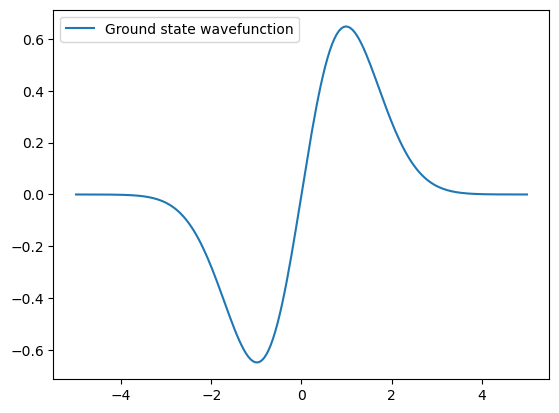

In [101]:
import numpy as np
import matplotlib.pyplot as plt

# Discretize space
x_min, x_max, N = -5, 5, 200
x = np.linspace(x_min, x_max, N)
dx = x[1] - x[0]
print(N)

# Hamiltonian pieces
laplacian = (-2*np.eye(N) + np.eye(N, k=1) + np.eye(N, k=-1)) / dx**2
T = -0.5 * laplacian
V = 0.5 * np.diag(x**2)
H = T + V

# Normalize
def normalize(psi):
    return psi / np.sqrt(np.sum(np.abs(psi)**2) * dx)

# Imaginary time evolution (gradient descent on energy functional)
#psi = np.exp(-x**2)        # initial guess
psi = np.random.rand(N)  # random initial guess
psi = normalize(psi)
dt = 0.001

for _ in range(2000):
    psi = psi - dt * (H @ psi)
    psi = 0.5 * (psi - psi[::-1])
    psi = normalize(psi)
    #plt.plot(psi)
    #plt.show()

# Compute ground state energy
E = np.real(np.vdot(psi, H @ psi) * dx)

print("Ground state energy ≈", E)

plt.plot(x, psi, label="Ground state wavefunction")
plt.legend()
plt.show()


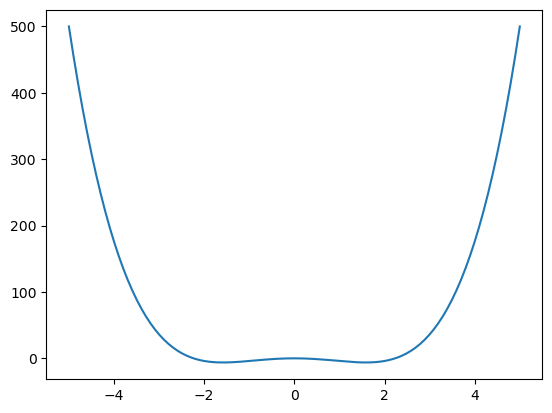

Converged after 28932 steps


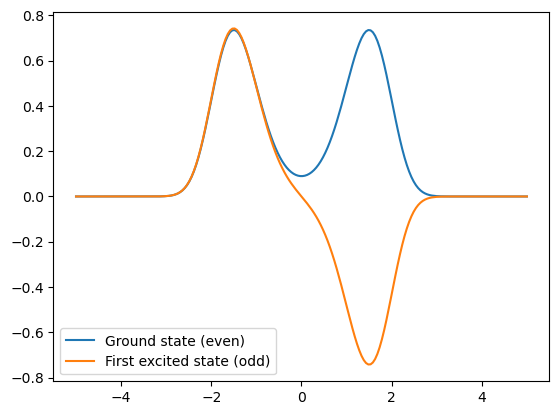

In [123]:
import numpy as np
import matplotlib.pyplot as plt

# --- Discretize space ---
g = 0.1
N = 10
x_min, x_max, Nx = -5, 5, 200
x = np.linspace(x_min, x_max, Nx)
dx = x[1] - x[0]

# --- Hamiltonian pieces ---
laplacian = (-2*np.eye(Nx) + np.eye(Nx, k=1) + np.eye(Nx, k=-1)) / dx**2
T = -0.5 * laplacian
V = np.diag(x**4) - 0.5 * np.diag(x**2) * 10
plt.plot(x, np.diag(V))
plt.show()
H = T + V

# --- Helpers ---
def normalize(psi):
    return psi / np.sqrt(np.sum(np.abs(psi)**2) * dx)

# --- Imaginary-time evolution parameters ---
dt = 1e-4
tol = 1e-8
max_steps = 200000

# --- Initial guesses ---
psi0 = normalize(np.random.rand(Nx))
psi1 = normalize(np.random.rand(Nx))

for step in range(max_steps):
    # store previous state
    old0 = psi0.copy()
    old1 = psi1.copy()

    # evolve
    psi0 = psi0 - dt * (H @ psi0 + g*N*psi0**3)
    psi1 = psi1 - dt * (H @ psi1 + g*N*psi1**3)

    # enforce parity
    psi0 = 0.5 * (psi0 + psi0[::-1])  # even
    psi1 = 0.5 * (psi1 - psi1[::-1])  # odd

    # normalize
    psi0 = normalize(psi0)
    psi1 = normalize(psi1)

    # check convergence
    diff0 = np.linalg.norm(psi0 - old0) * dx
    diff1 = np.linalg.norm(psi1 - old1) * dx
    if diff0 < tol and diff1 < tol:
        print(f"Converged after {step} steps")
        break

# --- Plot ---
plt.plot(x, psi0, label="Ground state (even)")
plt.plot(x, psi1, label="First excited state (odd)")
plt.legend()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Discretize space
x_min, x_max, N = -5, 5, 200
x = np.linspace(x_min, x_max, N)
dx = x[1] - x[0]
print(N)

# Hamiltonian pieces
laplacian = (-2*np.eye(N) + np.eye(N, k=1) + np.eye(N, k=-1)) / dx**2
T = -0.5 * laplacian
V = 0.5 * np.diag(x**2)
H = T + V

# Normalize
def normalize(psi):
    return psi / np.sqrt(np.sum(np.abs(psi)**2) * dx)

# Imaginary time evolution (gradient descent on energy functional)
#psi = np.exp(-x**2)        # initial guess
psi = np.random.rand(N)  # random initial guess
psi = normalize(psi)
dt = 0.001

for _ in range(2000):
    psi = psi - dt * (H @ psi)
    psi = 0.5 * (psi - psi[::-1])
    psi = normalize(psi)
    #plt.plot(psi)
    #plt.show()

# Compute ground state energy
E = np.real(np.vdot(psi, H @ psi) * dx)

print("Ground state energy ≈", E)

plt.plot(x, psi, label="Ground state wavefunction")
plt.legend()
plt.show()


In [132]:
import numpy as np
from scipy.linalg import eig_banded

def lowest_eigenvalue(a, b, c, N):
    """
    Compute the lowest eigenvalue of H = a S_z + b S_z^2 + c S_x^2
    for a spin S = N/2 using a banded representation and eigh_banded.
    """
    S = N / 2
    m = np.arange(-S, S + 1)
    dim = len(m)
    # Precompute coefficients for raising/lowering operators
    Sp2 = np.sqrt((S*(S+1)) - (m[0:-2]+1)*(m[0:-2]+2)) * np.sqrt((S*(S+1)) - (m[0:-2])*(m[0:-2]+1))
    #Sm2 = np.sqrt((S*(S+1)) - (m[2:]-1)*(m[2:]-2)) * np.sqrt((S*(S+1)) - (m[2:])*(m[2:]-1))
    Spm = S*(S+1) - m*(m-1)
    Smp = S*(S+1) - m*(m+1)

    diag = a*m + b*m**2 + c*(Spm + Smp)/4
    off2 = c*Sp2/4

    Ab = np.zeros((3, dim))
    Ab[0,:] = diag
    Ab[2,:-2] = off2
    
    return eig_banded(Ab, lower=True, eigvals_only=True, select = 'i', select_range = (0, 0))[0]


In [133]:
lowest_eigenvalue(1, 0, 0, 1)

-0.5

In [71]:
import numpy as np

# ============================
# Function to compute E0 from phi_+, phi_-
# ============================
def compute_E0_from_phis(x, phi_plus, phi_minus, Theta, a_bar, N):
    """
    Compute bar{E}_0 from discretized orthonormal modes phi_plus, phi_minus.

    Parameters
    ----------
    x : 1D array
        Discretized spatial grid
    phi_plus : 1D array
        Mode function phi_+(x)
    phi_minus : 1D array
        Mode function phi_-(x)
    Theta : 1D array
        Function Theta(x)
    a_bar : float
        Interaction coefficient
    N : int
        Particle number

    Returns
    -------
    dict
        Dictionary containing eps, U, alpha_plus, alpha_minus, beta, gamma, E0, E0_per_particle
    """
    M = x.size
    phis = np.vstack([phi_plus, phi_minus])  # shape (2, M)
    
    # Precompute kernel K(x) = \int |x-x'| Theta(x') dx'
    X = x.reshape((M,1))
    print(x)
    print(X)
    absdiff = np.abs(X - X.T)  # shape (M, M)
    K_of_x = np.trapz(absdiff * Theta.reshape((1,M)), x, axis=1)  # shape (M,)
    
    # Second derivative with central differences
    def second_derivative(f, x):
        d2 = np.empty_like(f)
        for i in range(1, M-1):
            h1 = x[i] - x[i-1]
            h2 = x[i+1] - x[i]
            d2[i] = 2.0*( f[i-1]/(h1*(h1+h2)) - f[i]/(h1*h2) + f[i+1]/(h2*(h1+h2)) )
        # boundary points: second-order one-sided
        d2[0] = (f[0] - 2*f[1] + f[2]) / ((x[1]-x[0])*(x[2]-x[1]))
        d2[-1] = (f[-3] - 2*f[-2] + f[-1]) / ((x[-2]-x[-3])*(x[-1]-x[-2]))
        return d2

    # Compute epsilon_{ij}
    eps = np.zeros((2,2))
    for i in range(2):
        for j in range(2):
            phi_i = phis[i]
            phi_j = phis[j]
            kinetic = -4.0 * second_derivative(phi_j, x)
            potential = K_of_x * phi_j
            eps[i,j] = np.trapz(phi_i * (kinetic + potential), x)

    # Vectorized computation of U_{ijkl}
    U = np.zeros((2,2,2,2))
    for i in range(2):
        for j in range(2):
            for k in range(2):
                for l in range(2):
                    left  = phis[i].reshape(M,1) * phis[l].reshape(M,1)  # shape (M,1)
                    right = phis[j].reshape(1,M) * phis[k].reshape(1,M)  # shape (1,M)
                    integrand = absdiff * (left @ right)  # shape (M,M)
                    U[i,j,k,l] = - (a_bar / N) * np.trapz(np.trapz(integrand, x, axis=1), x)

    # Map to alpha_plus, alpha_minus, beta, gamma
    alpha_plus  = U[0,0,0,0]
    alpha_minus = U[1,1,1,1]
    beta        = U[0,1,1,0]  # U_{+--+}
    gamma       = U[0,1,0,1]  # U_{+-+-}

    # Compute E0
    E0_per_particle = 0.5*(eps[0,0]+eps[1,1]) + ((N/2.0)-1.0)*0.5*(alpha_plus+alpha_minus) + (N/2.0)*beta + gamma
    E0 = N * E0_per_particle

    return {
        'eps': eps,
        'U': U,
        'alpha_plus': alpha_plus,
        'alpha_minus': alpha_minus,
        'beta': beta,
        'gamma': gamma,
        'E0': E0,
        'E0_per_particle': E0_per_particle
    }
""

''

In [72]:
# Example usage in a notebook cell
x = np.linspace(-5,5,1001)
def norm(f, x): 
    return f / np.sqrt(np.trapz(f*f, x))

phi_p = norm(np.exp(-(x-1.0)**2/0.8), x)
phi_m = norm(np.exp(-(x+1.0)**2/0.8), x)
Theta = np.zeros_like(x)
a_bar = 1.0
N = 10

out = compute_E0_from_phis(x, phi_p, phi_m, Theta, a_bar, N)
print("E0 =", out['E0'])
print("E0 / N =", out['E0_per_particle'])
print("alpha+ =", out['alpha_plus'])
print("alpha- =", out['alpha_minus'])
print("beta =", out['beta'])
print("gamma =", out['gamma'])


[-5.   -4.99 -4.98 ...  4.98  4.99  5.  ]
[[-5.  ]
 [-4.99]
 [-4.98]
 ...
 [ 4.98]
 [ 4.99]
 [ 5.  ]]
E0 = 37.97522713540263
E0 / N = 3.797522713540263
alpha+ = -0.050461599122044
alpha- = -0.05046159912204401
beta = -0.20002692712965842
gamma = -0.00034000758037343033


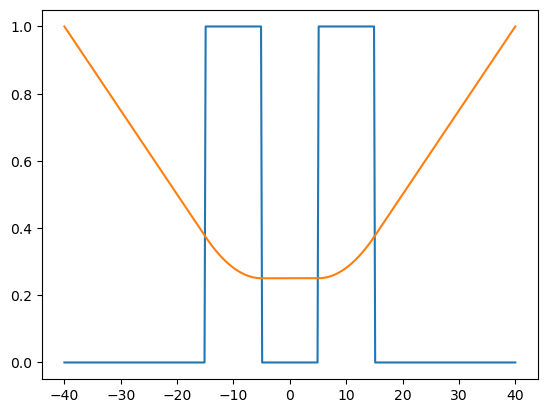

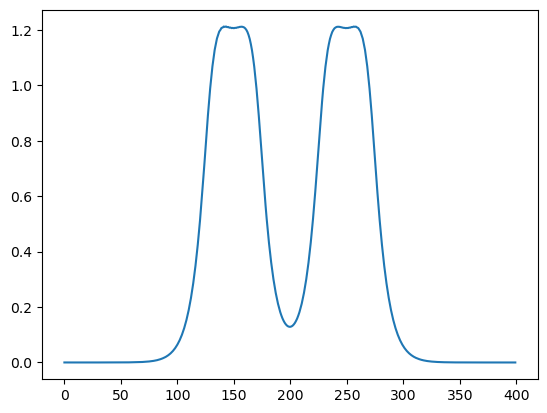

In [157]:
xmax = 40
nx = 400
L = 10
a = 10
x = np.linspace(-xmax, xmax, nx)
Theta = np.where(np.abs(np.abs(x)-(L+a)/2)<a/2, 1, 0)
M = x.size
X = x.reshape((M,1))
absdiff = np.abs(X - X.T)  # shape (M, M)
U = np.trapz(absdiff * Theta.reshape((1,M)), x, axis=1)  # shape (M,)

plt.plot(x, Theta)
plt.plot(x, U/max(U))
plt.show()


dx = x[1]-x[0]
#def d(phi, dx): 
#    pad = np.concatenate((np.array([0,0]), phi, np.array([0,0])))
#    return ((-1/12)*pad[4:] + (2/3)*pad[3:-1] - (2/3)*pad[1:-3] + (1/12)*pad[:-4])/dx
def d(phi, dx): 
    pad = np.concatenate((np.array([0]), phi, np.array([0])))
    return (pad[2:] - pad[:-2]) / (2*dx)

#def d(phi, dx): 
    #pad = np.concatenate((np.array([0,0]), phi, np.array([0,0])))
    #return ((-1/12)*pad[4:] + (2/3)*pad[3:-1] - (2/3)*pad[1:-3] + (1/12)*pad[:-4])/dx
def i(phi, dx, **kwargs):
    return np.sum(phi, **kwargs)*dx

U = i(absdiff*Theta.reshape((1,M)), dx, axis=1)


def H(phi):
    phi = phi / np.sqrt(i(phi**2, dx))
    K = 4*i(d(phi,dx)**2, dx)
    P = i(U*phi**2, dx)
    alpha = - a*i(phi**2 * i(absdiff * (phi**2).reshape((1,M)), dx, axis=1), dx) # shape (M,)
    #alpha = 0
    return K + P + alpha
initial_guess = np.random.rand(len(x))
result = minimize(H, initial_guess)#, method='L-BFGS-B')
plt.plot(result.x)
plt.show()

In [136]:
phi = result.x

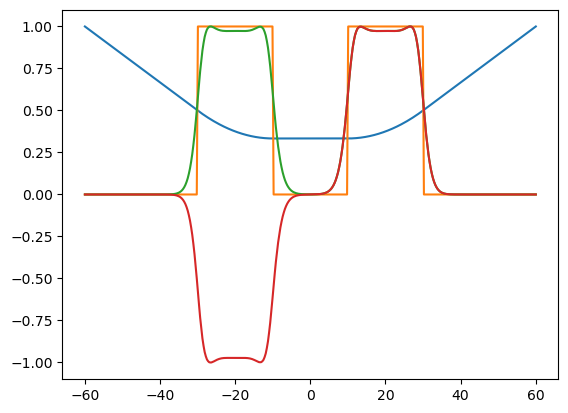

In [16]:
from numba import njit
from scipy.optimize import minimize
import numpy as np
from matplotlib import pyplot as plt

#initial_guess = result.x
def solve(xmax, nx, L, a, N):
    x = np.linspace(-xmax, xmax, nx)
    dx = x[1]-x[0]
    X = x.reshape((nx,1))
    absdiff = np.abs(X - X.T) 
    theta = np.where(np.abs(np.abs(x)-(L+a)/2)<a/2, 1, 0)
    
    @njit
    def d(phi, dx): 
        pad = np.concatenate((np.array([0]), phi, np.array([0])))
        return (pad[2:] - pad[:-2]) / (2*dx)
    @njit
    def i(phi, dx, axis):
        return np.sum(phi, axis)*dx
  
    U_ext = i(absdiff * theta.reshape((1,nx)), dx, 1)

    @njit
    def eps(phi):
        return i(4*d(phi, dx)**2 + U_ext*phi**2, dx, 0)

    @njit
    def U(phi_i, phi_j, phi_k, phi_l):
        left  = (phi_i*phi_l)
        right = (phi_j*phi_k).reshape(1,nx) 
        return -(a/N) * i(left*i(absdiff*right, dx, axis=1), dx, 0)

    @njit
    def alpha(phi):
        return U(phi, phi, phi, phi)

    @njit
    def beta(phi_p, phi_m):
        return U(phi_p, phi_m, phi_m, phi_p)

    @njit
    def gamma(phi_p, phi_m):
        return U(phi_p, phi_m, phi_p, phi_m)

    @njit
    def unpack(phis):
        phi_p, phi_m = phis[:nx//2], phis[nx//2:]
        phi_p = np.concatenate((np.flip(phi_p), phi_p))
        phi_m = np.concatenate((-np.flip(phi_m), phi_m))
        phi_p = phi_p / np.sqrt(i(phi_p**2, dx, 0))
        phi_m = phi_m / np.sqrt(i(phi_m**2, dx, 0))
        return phi_p, phi_m

    @njit
    def H(phis):
        phi_p, phi_m = unpack(phis)
        #one_mode =  (eps(phi_p) + eps(phi_m))/2 + (N-1)*(alpha(phi_p)+alpha(phi_m))/2
        #corrections = (N/2)*(beta(phi_p, phi_m) - (alpha(phi_p) + alpha(phi_m))/2) - gamma(phi_p, phi_m)
        Eps_p = eps(phi_p)
        Eps_m = eps(phi_m)
        Alpha_p = alpha(phi_p)
        Alpha_m = alpha(phi_m)
        Beta = beta(phi_p, phi_m)
        Gamma = gamma(phi_p, phi_m)
        #E0 = N/2 * (Eps_p + Eps_m) + N*(N/2-1)/2 * (Alpha_p + Alpha_m) + N*N/2 * Beta - N * Gamma
        E0 = ((Eps_p + Eps_m)/2 + (N/2-1)*(Alpha_p + Alpha_m)/2 + (N/2)*Beta - Gamma) # * N
        return E0
        return (eps(phi_p) + eps(phi_m))/2 + (N/2 - 1)*(alpha(phi_p) + alpha(phi_m))/2 + (N/2)*beta(phi_p, phi_m) - gamma(phi_p, phi_m)
        #return  one_mode + corrections

    #initial_guess = np.concatenate((theta[nx//2:], theta[nx//2:]))
    initial_guess = np.ones(nx)
    result = minimize(H, initial_guess)
    phi_p, phi_m = unpack(result.x)

    #plt.plot(x, U_ext/max(U_ext))
    plt.plot(x, theta)
    plt.plot(x, phi_p / max(phi_p), label='phi_+')
    plt.plot(x, phi_m / max(phi_m), label='phi_-')
    plt.show()
    return phi_p, phi_m

xmax = 60
nx = 400
L = 20
a = 20
N = 100
phi_p, phi_m = solve(xmax, nx, L, a, N)

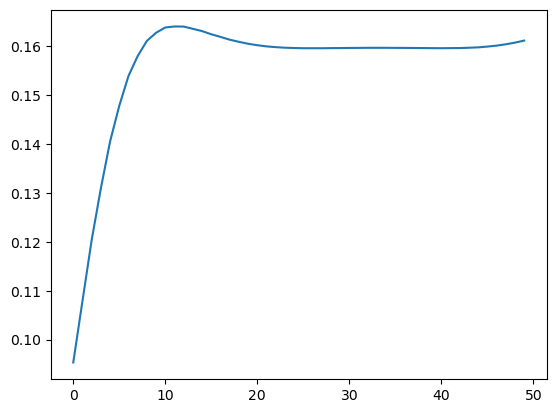